In [17]:
import argparse
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import yfinance as yf
from alpha_vantage.timeseries import TimeSeries
import utils as erk 
from datetime import date 
from sklearn.linear_model import RidgeCV, LassoCV

import advstatmodel

In [18]:
def load_ff_factors_local(csv_path: str) -> pd.DataFrame:
    # Find header row (line starting with ",Mkt-RF")
    with open(csv_path, "r", encoding="utf-8", errors="ignore") as f:
        lines = f.read().splitlines()
    header_i = next(i for i, line in enumerate(lines) if line.strip().startswith(",Mkt-RF"))

    ff = pd.read_csv(csv_path, skiprows=header_i)
    ff = ff.rename(columns={ff.columns[0]: "Date"})
    ff["Date"] = ff["Date"].astype(str).str.strip()
    ff = ff[ff["Date"].str.match(r"^\d{6}$")].copy()   # keep only YYYYMM
    ff["Date"] = pd.to_datetime(ff["Date"], format="%Y%m")
    ff = ff.set_index(ff["Date"].dt.to_period("M")).drop(columns=["Date"])
    ff = ff[["Mkt-RF", "SMB", "HML", "RF"]].astype(float) / 100.0
    return ff


def to_monthly_returns(adj_close: pd.DataFrame) -> pd.DataFrame:
    prices_m = adj_close.resample("M").last()
    rets_m = prices_m.pct_change().dropna()
    rets_m.index = rets_m.index.to_period("M")
    return rets_m


In [19]:


def _ols_alpha_tstat(y: pd.Series, X: pd.DataFrame):
    """
    Returns alpha (intercept), its t-stat, and full params for y ~ alpha + X.
    Uses statsmodels if available, else numpy OLS with classical SE.
    """
    y = y.dropna()
    X = X.loc[y.index].copy().dropna()
    y = y.loc[X.index]

    try:
        import statsmodels.api as sm
        res = sm.OLS(y, sm.add_constant(X)).fit()
        alpha = float(res.params["const"])
        tstat = float(res.tvalues["const"])
        return alpha, tstat, res.params
    except Exception:
        X_ = np.column_stack([np.ones(len(X)), X.values])
        y_ = y.values.reshape(-1, 1)
        beta = np.linalg.lstsq(X_, y_, rcond=None)[0]
        yhat = X_ @ beta
        resid = y_ - yhat
        n, k1 = X_.shape
        s2 = float((resid.T @ resid) / (n - k1))
        covb = s2 * np.linalg.inv(X_.T @ X_)
        se_alpha = float(np.sqrt(covb[0, 0]))
        alpha = float(beta[0, 0])
        tstat = alpha / se_alpha if se_alpha > 0 else np.nan
        params = pd.Series([alpha] + list(beta[1:, 0]), index=["const"] + list(X.columns))
        return alpha, tstat, params


def msr_forecasted_er_backtest(
    mret: pd.DataFrame,
    ff: pd.DataFrame,
    window: int = 60,
    model: str = "ridge",
    use_excess: bool = True,
    cv_folds: int = 5,
):
    """
    Predict next-month (excess) returns using lagged FF3 factors, then compute MSR weights.

    Features at time t are factors_{t-1} predicting return_t.
    At rebalance for month t, train on [t-window, t-1] and predict at t.

    Returns:
        pret_total: pd.Series (total portfolio returns)
        wts: pd.DataFrame (weights time series)
        yhat: pd.DataFrame (predicted excess returns per asset)
        yreal_excess: pd.DataFrame (realized excess returns per asset)
        ic: pd.Series (cross-sectional IC each month)
    """
    mret = mret.copy()
    ff = ff.copy()

    if not isinstance(mret.index, pd.PeriodIndex):
        mret.index = pd.to_datetime(mret.index).to_period("M")
    if not isinstance(ff.index, pd.PeriodIndex):
        ff.index = pd.to_datetime(ff.index).to_period("M")

    common_idx = mret.index.intersection(ff.index)
    mret = mret.loc[common_idx].dropna(how="any")
    ff = ff.loc[mret.index].dropna()

    X = ff[["Mkt-RF", "SMB", "HML"]].copy()
    X_lag = X.shift(1).dropna()

    if use_excess:
        y_excess = mret.sub(ff["RF"], axis=0)
    else:
        y_excess = mret.copy()

    y_excess = y_excess.loc[X_lag.index].dropna(how="any")
    X_lag = X_lag.loc[y_excess.index]
    dates = y_excess.index

    ridge_alphas = np.logspace(-4, 4, 50)
    lasso_alphas = np.logspace(-6, 1, 60)

    port_rets_total, weights_list, yhat_rows, ic_list = [], [], [], []

    for t in range(window, len(dates)):
        train_idx = dates[t - window:t]
        pred_idx = dates[t]

        X_train = X_lag.loc[train_idx].values
        X_pred = X_lag.loc[[pred_idx]].values

        cov = mret.loc[train_idx].cov()

        er_hat = []
        for col in y_excess.columns:
            y_train = y_excess.loc[train_idx, col].values

            if model.lower() == "ridge":
                reg = RidgeCV(alphas=ridge_alphas, fit_intercept=True).fit(X_train, y_train)
            elif model.lower() == "lasso":
                reg = LassoCV(alphas=lasso_alphas, cv=cv_folds, fit_intercept=True, max_iter=20000).fit(X_train, y_train)
            else:
                raise ValueError("model must be 'ridge' or 'lasso'")

            er_hat.append(float(reg.predict(X_pred)[0]))

        er_hat = pd.Series(er_hat, index=y_excess.columns)

        rf = 0.0 if use_excess else float(ff.loc[pred_idx, "RF"])
        w = pd.Series(erk.msr(rf, er_hat, cov), index=y_excess.columns)

        r_realized_total = float((w * mret.loc[pred_idx]).sum())

        y_real_ex = y_excess.loc[pred_idx]
        if y_real_ex.std(ddof=0) > 0 and er_hat.std(ddof=0) > 0:
            ic_val = float(np.corrcoef(er_hat.values, y_real_ex.values)[0, 1])
        else:
            ic_val = np.nan

        weights_list.append(w)
        port_rets_total.append(r_realized_total)
        yhat_rows.append(er_hat.rename(pred_idx))
        ic_list.append((pred_idx, ic_val))

    wts = pd.DataFrame(weights_list, index=dates[window:], columns=y_excess.columns)
    pret_total = pd.Series(port_rets_total, index=dates[window:], name=f"MSR_{model.upper()}_Forecast")
    yhat = pd.DataFrame(yhat_rows)
    yreal_excess = y_excess.loc[pret_total.index]
    ic = pd.Series({d: v for d, v in ic_list}, name=f"IC_{model.upper()}")
    return pret_total, wts, yhat, yreal_excess, ic


def evaluate_forecasts(yhat: pd.DataFrame, yreal: pd.DataFrame, ic: pd.Series, label: str):
    idx = yhat.index.intersection(yreal.index)
    yhat = yhat.loc[idx]
    yreal = yreal.loc[idx]

    err = (yreal - yhat)
    mse = float((err**2).stack().mean())
    mae = float(err.abs().stack().mean())

    sse = float((err**2).stack().sum())
    ybar = float(yreal.stack().mean())
    sst = float(((yreal - ybar)**2).stack().sum())
    r2 = 1 - sse / sst if sst > 0 else np.nan

    hit = float(((np.sign(yhat) == np.sign(yreal)).stack().mean()))

    ic_clean = ic.dropna()
    ic_mean = float(ic_clean.mean()) if len(ic_clean) else np.nan
    ic_std = float(ic_clean.std(ddof=1)) if len(ic_clean) > 1 else np.nan
    ic_t = ic_mean / (ic_std / np.sqrt(len(ic_clean))) if (ic_std and ic_std > 0) else np.nan

    print(f"\n=== Forecast Evaluation: {label} ===")
    print(f"Pooled MSE:  {mse:.6f}")
    print(f"Pooled MAE:  {mae:.6f}")
    print(f"OOS R^2:     {r2:.4f}")
    print(f"Hit-rate:    {hit:.3f}")
    print(f"Mean IC:     {ic_mean:.4f}")
    print(f"IC t-stat:   {ic_t:.2f}   (n={len(ic_clean)})")

    return {"mse": mse, "mae": mae, "r2": r2, "hit": hit, "ic_mean": ic_mean, "ic_t": ic_t}


def evaluate_alpha(strategy_rets: pd.Series, ff: pd.DataFrame, label: str):
    if not isinstance(strategy_rets.index, pd.PeriodIndex):
        strategy_rets.index = pd.to_datetime(strategy_rets.index).to_period("M")
    ff = ff.copy()
    if not isinstance(ff.index, pd.PeriodIndex):
        ff.index = pd.to_datetime(ff.index).to_period("M")

    idx = strategy_rets.index.intersection(ff.index)
    r = strategy_rets.loc[idx]
    rf = ff.loc[idx, "RF"]
    y = (r - rf).dropna()
    X = ff.loc[y.index, ["Mkt-RF", "SMB", "HML"]]

    alpha_m, alpha_t, params = _ols_alpha_tstat(y, X)
    alpha_ann = (1 + alpha_m) ** 12 - 1

    print(f"\n=== Alpha (FF3) for {label} ===")
    print(f"Monthly alpha:    {alpha_m:.5f}")
    print(f"Annualized alpha: {alpha_ann:.2%}")
    print(f"Alpha t-stat:     {alpha_t:.2f}")

    return {"alpha_monthly": alpha_m, "alpha_annualized": alpha_ann, "alpha_t": alpha_t, "params": params}


In [20]:
args = {
    "api_key" : "EE47LK8SIK07BAMH",
    "tickers": ["AAPL", "MSFT", "AMZN", "NVDA", "XOM", "JPM"],
    "start": "2010-01-01",
    "end": date.today(),
    "window" : 60 
}

In [21]:
adj = yf.download(args["tickers"], start=args["start"], end=args["end"], auto_adjust=True, progress=False)["Close"]
if isinstance(adj, pd.Series):
    adj = adj.to_frame(args.tickers[0])
mret = to_monthly_returns(adj)

print(adj)

ff = load_ff_factors_local("F-F_Research_Data_Factors.csv")  # relative path beside your script

Ticker            AAPL        AMZN         JPM        MSFT        NVDA  \
Date                                                                     
2010-01-04    6.418382    6.695000   28.423922   23.130058    0.423807   
2010-01-05    6.429481    6.734500   28.974495   23.137526    0.429995   
2010-01-06    6.327211    6.612500   29.133692   22.995531    0.432746   
2010-01-07    6.315514    6.500000   29.710796   22.756386    0.424265   
2010-01-08    6.357502    6.676000   29.637838   22.913326    0.425182   
...                ...         ...         ...         ...         ...   
2026-01-07  260.329987  241.559998  326.989990  483.470001  189.110001   
2026-01-08  259.040009  246.289993  329.790009  478.109985  185.039993   
2026-01-09  259.369995  247.380005  329.190002  479.279999  184.860001   
2026-01-12  260.250000  246.470001  324.489990  477.179993  184.940002   
2026-01-13  261.049988  242.600006  310.899994  470.670013  185.809998   

Ticker             XOM  
Date        

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_32528\3959087912.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  prices_m = adj_close.resample("M").last()


In [22]:
def main(args, mret, ff) :

    ew = erk.backtest_ws(mret, estimation_window=args["window"], weighting=erk.weight_ew)
    gmv_s = erk.backtest_ws(mret, estimation_window=args["window"], weighting=erk.weight_gmv, cov_estimator=erk.sample_cov)
    gmv_cc = erk.backtest_ws(mret, estimation_window=args["window"], weighting=erk.weight_gmv, cov_estimator=erk.cc_cov)
    gmv_sh = erk.backtest_ws(mret, estimation_window=args["window"], weighting=erk.weight_gmv, cov_estimator=erk.shrinkage_cov, delta=0.5)

    msr_ridge_ret, msr_ridge_wts, ridge_yhat, ridge_yreal, ridge_ic = msr_forecasted_er_backtest(
        mret, ff, window=args["window"], model="ridge", use_excess=True
    )
    msr_lasso_ret, msr_lasso_wts, lasso_yhat, lasso_yreal, lasso_ic = msr_forecasted_er_backtest(
        mret, ff, window=args["window"], model="lasso", use_excess=True
    )

    bt = pd.DataFrame({
        "EW": ew,
        "GMV-Sample": gmv_s,
        "GMV-CC": gmv_cc,
        "GMV-Shrink0.5": gmv_sh,
        "MSR-Ridge-Fcst": msr_ridge_ret,
        "MSR-Lasso-Fcst": msr_lasso_ret,
    }).dropna()

    print("\nSummary stats (monthly -> annualized):")
    print(erk.summary_stats(bt))

    evaluate_forecasts(ridge_yhat, ridge_yreal, ridge_ic, "Ridge")
    evaluate_forecasts(lasso_yhat, lasso_yreal, lasso_ic, "LASSO")

    # Alpha: highlight the key talking point
    evaluate_alpha(bt["EW"], ff, "EW (benchmark)")
    evaluate_alpha(bt["MSR-Ridge-Fcst"], ff, "MSR Ridge Forecast")
    evaluate_alpha(bt["MSR-Lasso-Fcst"], ff, "MSR LASSO Forecast")


    wealth = (1 + bt).cumprod()
    wealth.plot(title="Strategy Wealth (normalized)")
    plt.show()

    pd.DataFrame({"IC_Ridge": ridge_ic, "IC_Lasso": lasso_ic}).dropna().rolling(12).mean().plot(
        title="12M Rolling Information Coefficient (IC)"
    )
    plt.show()

    print("\nLast MSR-Ridge weights:")
    print(msr_ridge_wts.iloc[-1].sort_values(ascending=False))
    print("\nLast MSR-LASSO weights:")
    print(msr_lasso_wts.iloc[-1].sort_values(ascending=False))


Summary stats (monthly -> annualized):
                Annualized Return  Annualized Vol  Skewness  Kurtosis  \
EW                       0.309417        0.206635 -0.428370  3.186963   
GMV-Sample               0.242608        0.183258 -0.267324  3.559631   
GMV-CC                   0.239363        0.183191 -0.286957  3.536411   
GMV-Shrink0.5            0.240860        0.183199 -0.274595  3.546134   
MSR-Ridge-Fcst           0.315791        0.219191 -0.434850  3.203835   
MSR-Lasso-Fcst           0.309843        0.215453 -0.428952  3.137097   

                Cornish-Fisher VaR (5%)  Historic CVaR (5%)  Sharpe Ratio  \
EW                             0.080062            0.116862      1.316132   
GMV-Sample                     0.070371            0.103245      1.129126   
GMV-CC                         0.070868            0.103724      1.112287   
GMV-Shrink0.5                  0.070581            0.103337      1.120197   
MSR-Ridge-Fcst                 0.085866            0.120694    

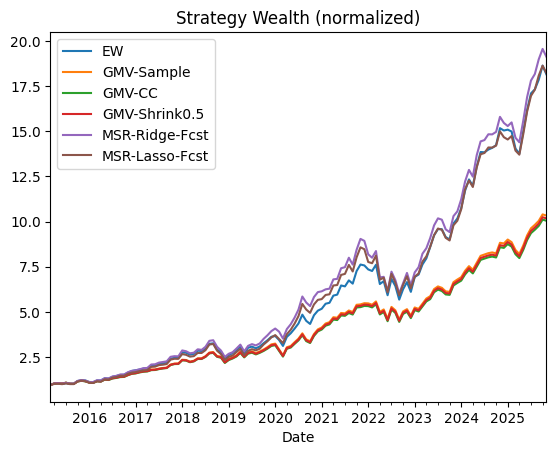

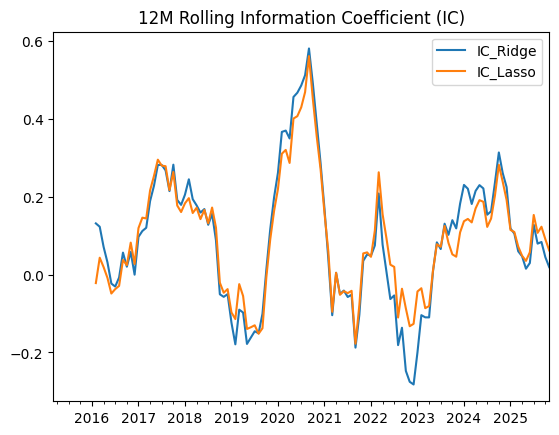


Last MSR-Ridge weights:
Ticker
AAPL    2.000000e-01
MSFT    2.000000e-01
XOM     2.000000e-01
NVDA    2.000000e-01
JPM     2.000000e-01
AMZN    2.775558e-17
Name: 2025-11, dtype: float64

Last MSR-LASSO weights:
Ticker
AAPL    2.000000e-01
JPM     2.000000e-01
XOM     2.000000e-01
NVDA    2.000000e-01
MSFT    2.000000e-01
AMZN    8.326673e-17
Name: 2025-11, dtype: float64


In [24]:
main(args, mret, ff)

In [30]:
def msr_forecasted_er_backtest(
    mret: pd.DataFrame, 
    ff: pd.DataFrame, 
    window: int = 60, 
    model: str = "best_subset", # Options: 'ridge', 'cvlasso', 'best_subset'
    use_excess: bool = True,
    max_vars: int = 2 # Only used if model == 'best_subset'
):
    """
    Predicts next-month returns using 'advstatmodel' library logic.
    """
    mret = mret.copy()
    ff = ff.copy()
    
    # --- Data Alignment (Same as before) ---
    if not isinstance(mret.index, pd.PeriodIndex):
        mret.index = pd.to_datetime(mret.index).to_period("M")
    if not isinstance(ff.index, pd.PeriodIndex):
        ff.index = pd.to_datetime(ff.index).to_period("M")
        
    common_idx = mret.index.intersection(ff.index)
    mret = mret.loc[common_idx].dropna(how="any")
    ff = ff.loc[mret.index].dropna()
    
    # Define Factor Names explicitly for the library
    factor_names = ["Mkt-RF", "SMB", "HML"]
    X = ff[factor_names].copy()
    X_lag = X.shift(1).dropna()
    
    if use_excess:
        y_excess = mret.sub(ff["RF"], axis=0)
    else:
        y_excess = mret.copy()
        
    y_excess = y_excess.loc[X_lag.index].dropna(how="any")
    X_lag = X_lag.loc[y_excess.index]
    dates = y_excess.index

    port_rets_total, weights_list, yhat_rows, ic_list = [], [], [], []
    
    print(f"Starting Backtest using model: {model.upper()}...")

    for t in range(window, len(dates)):
        train_idx = dates[t-window:t]
        pred_idx = dates[t]
        
        # 1. Prepare Data for Library (needs DataFrame with X and y)
        X_train_arr = X_lag.loc[train_idx].values
        X_pred_arr = X_lag.loc[[pred_idx]].values
        
        # Create a temporary training dataframe for advstatmodel
        train_df = pd.DataFrame(X_train_arr, columns=factor_names)
        
        cov = mret.loc[train_idx].cov()
        er_hat = []

        # Loop over every asset (stock)
        for col in y_excess.columns:
            y_train_vec = y_excess.loc[train_idx, col].values
            train_df["Target"] = y_train_vec # Attach current asset as target
            
            # 2. Set Options based on Model Choice
            if model.lower() == "ridge":
                method_name = "CVRidge"
                opts = advstatmodel.create_options_cv_ridge()
                opts['n_lambda'] = 50 
            elif model.lower() == "lasso" or model.lower() == "cvlasso":
                method_name = "CVLasso"
                opts = advstatmodel.create_options_cv_lasso()
            elif model.lower() == "best_subset":
                method_name = "BestSubset"
                opts = advstatmodel.create_options_best_subset()
                opts['max_vars'] = max_vars # Force top k factors
            else:
                raise ValueError("Model not supported")

            # 3. CALL YOUR LIBRARY
            # The library returns a fitted sklearn-compatible model
            reg_model = advstatmodel.run_factor_model(
                data=train_df,
                dependentVar="Target",
                factorNames=factor_names,
                method=method_name,
                options=opts
            )
            
            # 4. Predict
            # Sklearn models expect 2D array for prediction
            pred_val = reg_model.predict(X_pred_arr)[0]
            er_hat.append(float(pred_val))

        # --- Optimization & Recording (Same as before) ---
        er_hat = pd.Series(er_hat, index=y_excess.columns)
        rf_val = 0.0 if use_excess else float(ff.loc[pred_idx, "RF"])
        
        # Simple MSR (Max Sharpe Ratio) Optimizer
        # Note: Ensure you have 'erk' or 'minimize' imported or defined for this part
        # calculating naive MSR weights: w = Sigma^-1 * mu
        try:
            inv_cov = np.linalg.inv(cov)
            w_raw = inv_cov @ er_hat
            w = w_raw / w_raw.sum() # Normalize to 1
        except:
            w = pd.Series([1/len(er_hat)]*len(er_hat), index=er_hat.index) # Fallback

        w = pd.Series(w, index=y_excess.columns)
        r_realized = float((w * mret.loc[pred_idx]).sum())
        
        # Calculate IC
        y_real_ex = y_excess.loc[pred_idx]
        if y_real_ex.std() > 0 and er_hat.std() > 0:
            ic_val = np.corrcoef(er_hat, y_real_ex)[0,1]
        else:
            ic_val = np.nan
            
        weights_list.append(w)
        port_rets_total.append(r_realized)
        yhat_rows.append(er_hat.rename(pred_idx))
        ic_list.append((pred_idx, ic_val))
        
    wts = pd.DataFrame(weights_list, index=dates[window:], columns=y_excess.columns)
    pret = pd.Series(port_rets_total, index=dates[window:], name=f"MSR_{model}")
    yhat = pd.DataFrame(yhat_rows)
    ic = pd.Series({d:v for d,v in ic_list}, name="IC")
    
    return pret, wts, yhat, ic


# ==========================================
# 3. RUN THE BACKTEST
# ==========================================
# Assuming 'mret' (returns) and 'ff' (factors) are already loaded in your environment:
strategy_ret, weights, predictions, ic_ts = msr_forecasted_er_backtest(
    mret=mret, 
    ff=ff, 
    window=60, 
    model="best_subset", # Uses your library's MIP Solver
    max_vars=2           # Pick only the best 2 factors
)

# Standard Metrics
print(f"Annualized Return: {strategy_ret.mean()*12:.2%}")
print(f"Information Coeff: {ic_ts.mean():.4f}")

# ==========================================
# 4. CUSTOM STATS USING YOUR LIBRARY
# ==========================================
print("\n=== Generating Custom Factor Loading Analysis ===")
print("Using 'compute_trailing_factor_regressions' from advstatmodel...")

# We will run this on the Strategy Returns themselves to see 
# "What factors was the Strategy betting on?"

# Prepare data for the library function
analysis_df = ff.copy()
analysis_df["Strategy_Ret"] = strategy_ret
analysis_df["Date"] = analysis_df.index.to_timestamp() # Library likes datetime columns

# Create Options
options_analysis = advstatmodel.create_options_cv_lasso() # Or OLS
options_analysis['time_period'] = 'all'

# Call the library function
# Note: 'window' here is for the post-hoc analysis, can be different from backtest
factor_betas = advstatmodel.compute_trailing_factor_regressions(
    data=analysis_df,
    dependentVar="Strategy_Ret",
    factorNames=["Mkt-RF", "SMB", "HML"],
    window=36, 
    method="OLS", # OLS is good for simple attribution
    options=options_analysis,
    dateCol="Date",
    printTime=True
)

# Plotting the Custom Stats
factor_betas.set_index("Date")[["Mkt-RF", "SMB", "HML"]].plot(
    title="Strategy Factor Exposures (Trailing 36m)", 
    figsize=(10, 5)
)
plt.axhline(0, color='black', linewidth=0.5)
plt.ylabel("Beta")
plt.show()

Starting Backtest using model: BEST_SUBSET...


SolverError: The solver ECOS_BB is not installed.

In [29]:
import cvxpy
print(cvxpy.installed_solvers())

['CLARABEL', 'ECOS', 'ECOS_BB', 'OSQP', 'SCIPY', 'SCS']
